# Testing decision tree decision path to compute infimum under $\nu$

In [35]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
import pandas as pd
import statsmodels.api as sm
import scipy.stats as st

from CP2LFI.scores import Scores, LambdaScore, BFFScore
from CP2LFI.loforest import ConformalLoforest
from clover import LocartSplit


# importing functions to adapt estimated cutoffs
from CP2LFI.nuissance import TRUST_nuisance_cutoffs, TRUST_plus_nuisance_cutoff
from sklearn.ensemble import HistGradientBoostingRegressor

import torch
from CP2LFI.utils import fit_post_model
from CP2LFI.simulations import GLM_stat
from torch.distributions.uniform import Uniform
from torch.distributions.poisson import Poisson
from torch.distributions.gamma import Gamma
import itertools
from tqdm import tqdm

## Testing CART atributes to compute nuisance cutoff:

In [36]:
# Simulate data using sklearn function
X_train, y_train = make_regression(n_samples=50, n_features=3, random_state=42)

# Create a decision tree regressor object
regressor = DecisionTreeRegressor(max_leaf_nodes=5, random_state=0)

# Fit the regressor to the training data
regressor.fit(X_train, y_train)

# Predict the target variable for the test data
X_test = np.array([[2, 3, 4], [5, 6, 7]])
y_pred = regressor.predict(X_test)

x[0] is our parameter os interest and x[1] and x[2] are nuissance:

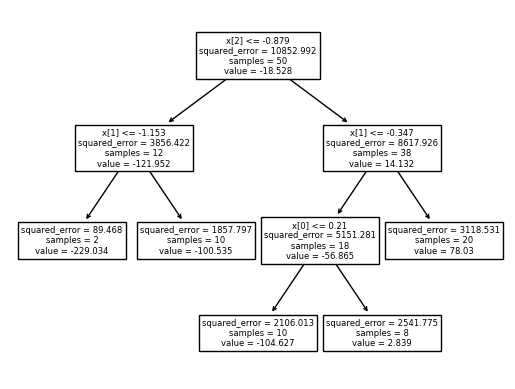

In [37]:
tree.plot_tree(regressor)
plt.show()

Exploring tree structure:

In [38]:
n_nodes = regressor.tree_.node_count
children_left = regressor.tree_.children_left
children_right = regressor.tree_.children_right
feature = regressor.tree_.feature
threshold = regressor.tree_.threshold
values = regressor.tree_.value

In [39]:
children_left

array([ 1,  7,  3,  5, -1, -1, -1, -1, -1], dtype=int64)

In [40]:
children_right

array([ 2,  8,  4,  6, -1, -1, -1, -1, -1], dtype=int64)

In [41]:
feature

array([ 2,  1,  1,  0, -2, -2, -2, -2, -2], dtype=int64)

In [42]:
threshold

array([-0.87932089, -1.1526942 , -0.34739607,  0.21025595, -2.        ,
       -2.        , -2.        , -2.        , -2.        ])

In [43]:
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)

while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

In [44]:
regressor.apply(X_test)

array([4, 4])

Exploring tree in each level:

In [45]:
print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node with value={value}.".format(
                space=node_depth[i] * "\t", node=i, value=values[i]
            )
        )
    else:
        print(
            "{space}node={node} is a split node with value={value}: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
                value=values[i],
            )
        )

The binary tree structure has 9 nodes and has the following tree structure:

node=0 is a split node with value=[[-18.52785519]]: go to node 1 if X[:, 2] <= -0.87932088971138 else to node 2.
	node=1 is a split node with value=[[-121.95151352]]: go to node 7 if X[:, 1] <= -1.152694195508957 else to node 8.
	node=2 is a split node with value=[[14.13224745]]: go to node 3 if X[:, 1] <= -0.3473960682749748 else to node 4.
		node=3 is a split node with value=[[-56.86472587]]: go to node 5 if X[:, 0] <= 0.2102559469640255 else to node 6.
		node=4 is a leaf node with value=[[78.02952343]].
			node=5 is a leaf node with value=[[-104.62743522]].
			node=6 is a leaf node with value=[[2.83866081]].
		node=7 is a leaf node with value=[[-229.03435438]].
		node=8 is a leaf node with value=[[-100.53494535]].


## Strategy to obtain nuisance-free cutoff:

### Implementing nuisance-adapted functions for each method

Implementing naive quantiles in the presence of nuisance parameter:

In [46]:
def naive_nuisance(
    kind,
    simulator,
    score,
    alpha,
    nuisance_idx,
    B=1000,
    N=100,
    naive_n=500,
    disable_tqdm=True,
    log_transf=False,
):
    n_grid = int(B / naive_n)
    quantiles = {}

    if kind == "poisson":
        # given the complexity, reducing to only 10 grid if B > 5000
        nu_grid = np.linspace(0.51, 1.49, int(np.ceil(n_grid ** (1 / 2))))
        mu_grid = np.linspace(0.1, 4.9, int(np.ceil(n_grid ** (1 / 2))))


        for nu, mu in tqdm(itertools.product(nu_grid, mu_grid), 
                           desc="fitting monte carlo cutoffs",
                           ):
            theta_fixed = torch.tensor([nu, mu])
            repeated_thetas = theta_fixed.reshape(1, -1).repeat_interleave(
                repeats=naive_n * N, dim=0
            )
            X_samples = simulator(repeated_thetas)

            if log_transf:
                X_samples = torch.log(X_samples)

            X_dim = X_samples.shape[1]
            X_samples = X_samples.reshape(naive_n, N * X_dim)

            lambdas = score.compute_nuissance(
            thetas=repeated_thetas.numpy()[0:naive_n, :],
                X=X_samples.numpy(), nuissance_idx = nuisance_idx, disable_tqdm=disable_tqdm, posterior_marginalized = True,
            )

            quantiles[(nu, mu)] = np.quantile(lambdas, q=1 - alpha)

    # TODO: glm with five parameters
    return quantiles

def predict_naive_quantile(kind, theta_grid, quantiles_dict):
    thetas_values = np.array(list(quantiles_dict.keys()))
    quantiles_list = []
    for theta in theta_grid:
        if kind == "weinberg":
            idx = thetas_values[int(np.argmin(np.abs(theta - thetas_values)))]
            quantiles_list.append(quantiles_dict[idx])
        else:
            distances = np.linalg.norm(thetas_values - theta, axis=1)
            idx = thetas_values[np.argmin(distances)]
            quantiles_list.append(quantiles_dict[tuple(idx)])
    return quantiles_list

Implementing all methods nuisance cutoffs:

In [47]:
def TRUST_nuisance_cutoffs(
        trust_obj, 
        nuissance_idx,
        par_values,
        trust_quantiles,
        ):
    # returning all thresholds
    feature_array = np.array(trust_obj.cart.tree_.feature)
    threshold_array = np.array(trust_obj.cart.tree_.threshold)

    # cutoff array
    cutoff_nuis = np.zeros(par_values.shape[0])

    # returning all index
    size = par_values.shape[1] + 1

    # idx list
    idx_array = np.arange(0, size)
    

    # selecting threshold_array with feature array equal to nuissance idx
    if isinstance(nuissance_idx, int):
        par_idx = idx_array[np.where(idx_array != nuissance_idx)]
        par_reorder = np.argsort(
            np.concatenate((par_idx, nuissance_idx), axis = None)
            )

        idxs = np.where(feature_array == nuissance_idx)
        thres = threshold_array[idxs]

        if thres.shape[0] != 0:
            # choosing eps by pairwise distances
            dists = pairwise_distances(thres.reshape(-1, 1))
            upper_triangular_indices = np.triu_indices(dists.shape[0], k=1)
            eps = np.min(dists[upper_triangular_indices])*1/3

            nuis_values = np.concatenate((thres - eps, thres + eps), axis = None)

            i = 0
            for par in par_values:
                par_array = np.tile(par, reps = (nuis_values.shape[0], 1))
                new_par = np.column_stack((par_array, nuis_values))

                # reordering columns
                new_par = new_par[:, par_reorder]

                # computing cutoffs for new par
                idxs = trust_obj.cart.apply(new_par)
                list_locart_quantiles = np.array([trust_quantiles[idx] for idx in idxs])

                # returning minimal value
                cutoff_nuis[i] = np.max(list_locart_quantiles)
                i += 1
        # if thres is empty, then TRUST does not depend on nuisance
        else:
            i = 0
            for par in par_values:
                new_par = np.column_stack((par, 0))
                idxs = trust_obj.cart.apply(new_par)
                list_locart_quantiles = np.array([trust_quantiles[idx] for idx in idxs])

                cutoff_nuis[i] = list_locart_quantiles[0]
                i += 1
            
    else:
        # finding index of parameter of interest
        par_idx = np.setdiff1d(idx_array, nuissance_idx)
        par_reorder = np.argsort(
            np.concatenate(
            (par_idx, nuissance_idx), axis = None)
            )
        
        # finding indexes for nuisance threshold
        idxs_thres = np.where(np.in1d(feature_array,nuissance_idx))
        thres = threshold_array[idxs_thres]

        # if there are any nuisance thresholds
        if thres.shape[0] != 0:
            feature_nuis = feature_array[idxs_thres]

            # looping through all analysed features
            feature_idx = np.unique(feature_nuis)
            used_idx_list = []
            nuis_list = []

            # looping through features
            for feature in feature_idx:
                idx = np.where(feature_nuis == feature)
                thres_sel = thres[idx]

                used_idx_list.append(np.where(nuissance_idx == feature)[0][0])

                if thres_sel.shape[0] > 1:
                    # choosing eps in this case
                    dists = pairwise_distances(thres_sel.reshape(-1, 1))
                    upper_triangular_indices = np.triu_indices(dists.shape[0], k=1)
                    eps = np.min(dists[upper_triangular_indices])*1/3
                else:
                    eps = 0.05

                nuis_values = np.concatenate(
                    (thres_sel - eps, thres_sel + eps), 
                    axis = None
                    )
                nuis_list.append(nuis_values)

            # array of used indexes
            used_idx_array = np.array(used_idx_list)
            
            # checking if any nuisance feature was not used as threshold  
            # and fixing a value to it
            idx_diff = np.setdiff1d(nuissance_idx, feature_idx)
            unused_idx_list = []
            if idx_diff.shape[0] != 0:
                for i in range(idx_diff.shape[0]):
                    unused_idx_list.append(
                        np.where(nuissance_idx == idx_diff[i])[0][0]
                        )
                    nuis_list.append(np.array([0]))
                # array of unused indexes
                unused_idx_array = np.array(unused_idx_list)

                # reordering all combinations
                all_nuis_combinations = np.c_[list(itertools.product(*nuis_list))]

                # correcting order
                nuisance_reorder = np.argsort(
                    np.concatenate(
                    (used_idx_array, unused_idx_array),
                    axis = None
                    ))

                nuis_values = all_nuis_combinations[:, nuisance_reorder]
            else:
                nuis_values = np.c_[list(itertools.product(*nuis_list))]
            
            
            i = 0
            for par in par_values:
                par_array = np.tile(par, reps = (nuis_values.shape[0], 1))
                new_par = np.column_stack((par_array, nuis_values))

                # reordering columns
                new_par = new_par[:, par_reorder]

                # computing cutoffs for new par
                idxs = trust_obj.cart.apply(new_par)
                list_locart_quantiles = np.array([trust_quantiles[idx] for idx in idxs])

                # returning minimal value
                cutoff_nuis[i] = np.max(list_locart_quantiles)
                i += 1
    
    # conditioning if the threshold does not depend on other parameters
        else:
            # make vector of zeroes for the other parameters
            zeroes = np.zeros((1, nuissance_idx.shape[0]))
            i = 0
            for par in par_values:
                if par.ndim == 0:
                    par_col = par.reshape(1,1)
                else:
                    par_col = par.reshape(1,-1)

                new_par = np.column_stack((par_col, zeroes))
                # reordering columns
                new_par = new_par[:, par_reorder]

                idxs = trust_obj.cart.apply(new_par)
                list_locart_quantiles = np.array([trust_quantiles[idx] for idx in idxs])

                cutoff_nuis[i] = list_locart_quantiles[0]
                i += 1
    return cutoff_nuis

def TRUST_plus_nuisance_cutoff(
        trust_plus_obj,
        nuissance_idx,
        par_values,
        K = 100,
        strategy = "all_cutoffs",
        total_h_cutoffs = 50,
        ):
    n_trees = len(trust_plus_obj.RF.estimators_)
    threshold_list = []
    feature_list = []

    if strategy == "all_cutoffs":
        # returning all thresholds for each tree
        for tree in trust_plus_obj.RF.estimators_:
            feature_array = np.array(tree.tree_.feature)
            threshold_array = np.array(tree.tree_.threshold)

            idxs = np.where(feature_array == nuissance_idx)
            thres = threshold_array[idxs]
            feature_nuis = feature_array[idxs]
            
            threshold_list.extend(list(thres))
            feature_list.extend(list(feature_nuis))
        thres = np.array(threshold_list)

    elif strategy == "one_tree":
        feature_array = np.array(
            trust_plus_obj.nuisance_tree.tree_.feature
            )
        threshold_array = np.array(
            trust_plus_obj.nuisance_tree.tree_.threshold
            )
        idxs = np.where(feature_array == nuissance_idx)
        thres = threshold_array[idxs]

    elif strategy == "horizontal_cutoffs":
        total_cutoffs = 0
        tree_position = 0
        # making list of features and thresholds
        tree_feature_list, tree_thres_list = [], []
        feature_list, thres_list = [], []
        # creating feature and tree threshold list
        for tree in trust_plus_obj.RF.estimators_:
            feature_array = np.array(tree.tree_.feature)
            threshold_array = np.array(tree.tree_.threshold)

            tree_feature_list.append(feature_array)
            tree_thres_list.append(threshold_array)
        
        # returning only the first thresholds in trees
        while total_cutoffs < total_h_cutoffs:
            for i in range(n_trees):
                curr_feature = tree_feature_list[i][tree_position]
                if isinstance(nuissance_idx, int):
                    if curr_feature == nuissance_idx:
                        thres_list.append(tree_thres_list[i][tree_position])
                        feature_list.append(curr_feature)
                        total_cutoffs += 1
                        if total_cutoffs == total_h_cutoffs:
                            break
                else:
                     if curr_feature in nuissance_idx:
                        thres_list.append(tree_thres_list[i][tree_position])
                        feature_list.append(curr_feature)
                        total_cutoffs += 1
                        if total_cutoffs == total_h_cutoffs:
                            break
            tree_position += 1
        thres = np.array(thres_list)
        feature_nuis = np.array(feature_list)

    # cutoff array
    cutoff_nuis = np.zeros(par_values.shape[0])

    # returning all index
    size = par_values.shape[1] + 1
    # idx list
    idx_array = np.arange(0, size)

    # selecting threshold_array with feature array equal to nuissance idx
    if isinstance(nuissance_idx, int):
        par_idx = idx_array[np.where(idx_array != nuissance_idx)]
        par_reorder = np.argsort(
            np.concatenate((par_idx, nuissance_idx), axis = None)
            )
        
        # choosing eps by pairwise distances
        dists = pairwise_distances(thres.reshape(-1, 1))
        upper_triangular_indices = np.triu_indices(dists.shape[0], k=1)
        eps = np.min(dists[upper_triangular_indices])*1/3

        nuis_values = np.concatenate((thres - eps, thres + eps), axis = None)
        print(f"Using {nuis_values.shape[0]} nuisance candidates")

        par_idx = idx_array[np.where(idx_array != nuissance_idx)]
        par_reorder = np.concatenate((par_idx, nuissance_idx), axis = None)

        i = 0
        for par in tqdm(par_values, desc = "Computing nuisance cutoffs for each parameter value"):
            par_array = np.tile(par, reps = (nuis_values.shape[0], 1))
            new_par = np.column_stack((par_array, nuis_values))

            # reordering columns
            new_par = new_par[:, par_reorder]

            # computing cutoffs for new par
            cutoff_vector = trust_plus_obj.compute_cutoffs(new_par, K = K)

            # returning minimal value
            cutoff_nuis[i] = np.max(cutoff_vector)
            i += 1
    else:
        # reordering parameters order
        par_idx = np.setdiff1d(idx_array, nuissance_idx)
        par_reorder = np.argsort(
            np.concatenate((par_idx, nuissance_idx), axis = None)
        )  

        # looping through all used nuisance features
        feature_idx = np.unique(feature_nuis)

        nuis_list = []
        used_idx_list = []
        for feature in feature_idx:
            idxs = np.where(feature_nuis == feature)
            used_idx_list.append(np.where(nuissance_idx == feature)[0][0])
            thres_sel = thres[idxs]

            dists = pairwise_distances(thres_sel.reshape(-1, 1))
            upper_triangular_indices = np.triu_indices(dists.shape[0], k=1)
            eps = np.min(dists[upper_triangular_indices])*1/3

            nuis_values = np.concatenate(
                (thres_sel - eps, thres_sel + eps), 
                axis = None
                )
            nuis_list.append(nuis_values)

        used_idx_array = np.array(used_idx_list)
        
        # checking if any feature didnt appear and fixing a value to it
        idx_diff = np.setdiff1d(nuissance_idx, feature_idx)
        unused_idx_list = []
        if idx_diff.shape[0] != 0:
            for i in range(idx_diff.shape[0]):
                nuis_list.append(np.array([0]))
                unused_idx_list.append(
                        np.where(nuissance_idx == idx_diff[i])[0][0]
                        )
                nuis_list.append(np.array([0]))
                unused_idx_array = np.array(unused_idx_list)

            # reordering all combinations
            all_nuis_combinations = np.c_[list(itertools.product(*nuis_list))]
            nuisance_reorder = np.argsort(
                np.concatenate(
                    (used_idx_array, unused_idx_array),
                    axis = None
                    )
                    )
            all_nuis_combinations = all_nuis_combinations[:, nuisance_reorder]
        else:
            all_nuis_combinations = np.c_[list(itertools.product(*nuis_list))]
        
        print(f"Total number of combinations: {all_nuis_combinations.shape[0]}")
        i = 0
        for par in tqdm(par_values, desc = "Computing nuisance cutoffs for each parameter value"):
            par_array = np.tile(par, reps = (all_nuis_combinations.shape[0], 1))
            new_par = np.column_stack((par_array, all_nuis_combinations))

            # reordering columns
            new_par = new_par[:, par_reorder]

            # computing cutoffs for new par
            cutoff_vector = trust_plus_obj.compute_cutoffs(new_par, K = K)

            # returning minimal value
            cutoff_nuis[i] = np.max(cutoff_vector)
            i += 1

    return cutoff_nuis

def boosting_nuisance_cutoff(
        boosting_obj,
        nuisance_grid,
        nuissance_idx,
        par_values,
        ):
    # cutoff array
    cutoff_nuis = np.zeros(par_values.shape[0])

    # returning all index
    size = par_values.shape[1] + 1
    # idx list
    idx_array = np.arange(0, size)
    if isinstance(nuissance_idx, int):
        par_idx = idx_array[np.where(idx_array != nuissance_idx)]
    else:
        par_idx = np.setdiff1d(idx_array, nuissance_idx)
        
    par_reorder = np.argsort(
        np.concatenate((par_idx, nuissance_idx), axis = None)
        )

    i = 0
    for par in tqdm(par_values, desc = "Computing nuisance cutoffs for each parameter value in boosting"):
        par_array = np.tile(par, reps = (nuisance_grid.shape[0], 1))
        new_par = np.column_stack((par_array, nuisance_grid))

        # reordering columns
        new_par = new_par[:, par_reorder]

        # computing cutoffs for new par
        cutoff_vector = boosting_obj.predict(new_par)

        # returning minimal value
        cutoff_nuis[i] = np.max(cutoff_vector)
        i += 1
    return cutoff_nuis

def naive_nuisance_cutoff(
        naive_quantiles,
        nuisance_grid,
        nuisance_idx,
        par_values,
):
    # cutoff array
    cutoff_nuis = np.zeros(par_values.shape[0])

    if isinstance(nuisance_idx, int):
        # returning all index
        size = par_values.shape[1] + 1
        # idx list
        idx_array = np.arange(0, size)
        par_idx = idx_array[np.where(idx_array != nuisance_idx)]
        par_reorder = np.concatenate((par_idx, nuisance_idx), axis = None)

        i = 0
        for par in tqdm(par_values, desc = "Computing nuisance cutoffs for each parameter value in boosting"):
            par_array = np.tile(par, reps = (nuisance_grid.shape[0], 1))
            new_par = np.column_stack((par_array, nuisance_grid))

            # reordering columns
            new_par = new_par[:, par_reorder]

            # computing cutoffs with naive
            cutoff_vector = np.array(predict_naive_quantile(kind = "poisson", theta_grid = new_par, quantiles_dict = naive_quantiles))

            # returning minimal value
            cutoff_nuis[i] = np.max(cutoff_vector)
            i += 1
        return cutoff_nuis
    # TODO: nuisance with more than 1 dimension

Function to compute coverage and real nuisance cutoff:

In [48]:
# computing coverage for the poisson example
def coverage_nuisance(cutoff_array_trust, 
                      cutoff_array_trust_plus,
                      cutoff_boosting,
                      cutoff_naive,
                      valid_thetas,
                      par_space,
                      score,
                      simulator,
                      nuisance_idx,
                      par_idx,
                      n_lambda = 1000,
                      n = 5,):
    
    coverage_trust, coverage_trust_plus = np.zeros(valid_thetas.shape[0]), np.zeros(valid_thetas.shape[0])
    coverage_boosting, coverage_naive = np.zeros(valid_thetas.shape[0]), np.zeros(valid_thetas.shape[0])
    cutoff_trust_list, cutoff_trust_plus_list = [], []
    real_cutoff_list, boosting_cutoff_list = [], []
    naive_cutoff_list = []
    stat_list, mu_list, problem_cutoff = [], [], []
    i = 0

    # computing coverage for trust, trust++, boosting and naive
    for theta in tqdm(valid_thetas, desc = "Assessing "):
        cut_idx = np.where(par_space == theta[par_idx])
        # generating stats
        theta_repeated = torch.tensor([theta], 
                                      dtype = torch.float32
                                      ).reshape(
                                          1, -1).repeat_interleave(
                                          repeats = n_lambda*n, 
                                          dim = 0
                                          )
        X_net = simulator(theta_repeated)
        X_dim = X_net.shape[1]
        X_net = X_net.reshape(n_lambda, n * X_dim)

        stat = score.compute_nuissance(
            theta_repeated.numpy()[0:n_lambda,:], 
            X_net.numpy(), 
            nuissance_idx = nuisance_idx, 
            disable_tqdm = True,
            posterior_marginalized=True,
            )
        
        real_cutoff = np.quantile(stat, q = 0.95)
        coverage_trust[i] = np.mean(stat <= cutoff_array_trust[cut_idx])
        coverage_trust_plus[i] = np.mean(stat <= cutoff_array_trust_plus[cut_idx])
        coverage_boosting[i] = np.mean(stat <= cutoff_boosting[cut_idx])
        coverage_naive[i] = np.mean(stat <= cutoff_naive[cut_idx])

        # detecting cases where coverage is zero in TRUST
        if coverage_trust[i] < 0.1:
            stat_list.append(stat)
            mu_list.append(theta[1])
            problem_cutoff.append(cutoff_array_trust[cut_idx])
        
        # adding every cutoff in the list
        cutoff_trust_plus_list.append(cutoff_array_trust_plus[cut_idx])
        boosting_cutoff_list.append(cutoff_boosting[cut_idx])
        naive_cutoff_list.append(cutoff_naive[cut_idx])

        # returning cutoff for TRUST to evaluate
        cutoff_trust_list.append(cutoff_array_trust[cut_idx])
        real_cutoff_list.append(real_cutoff)
        i += 1
    
    # transforming the lists into arrays
    trust_grid_cutoff_array = np.array(cutoff_trust_list)
    trust_grid_plus_cutoff_array = np.array(cutoff_trust_plus_list)
    boosting_cutoff_array = np.array(boosting_cutoff_list)
    naive_cutoff_array = np.array(naive_cutoff_list)
    
    # computing real nuisance cutoff using real cutoffs from past loop
    real_cutoff =  np.array(real_cutoff_list)
    real_nuisance_cutoff_list = []
    for theta in tqdm(valid_thetas, desc = "Computing real cutoffs: "):
        cut_idxs = np.where(valid_thetas[:, par_idx] == theta[par_idx])
        real_nuisance_cutoff = np.max(real_cutoff[cut_idxs])
        real_nuisance_cutoff_list.append(real_nuisance_cutoff)
    
    # transforming the list into array
    real_grid_cutoff_array = np.array(real_nuisance_cutoff_list)
    
    # computing TRUST, TRUST++, Boosting and real cutoffs only for mu
    # in poisson example
    real_mu_list, trust_mu_list, trust_plus_mu_list = [], [], []
    boosting_mu_list = []
    for mu in tqdm(par_space, desc = "Computing cutoffs only for mu: "):
        cut_idx = np.where(valid_thetas[:, 1] == mu)
        real_mu_nuisance_cutoff = np.unique(
            real_grid_cutoff_array[cut_idx])[0]
        trust_mu_nuisance_cutoff = np.unique(
            trust_grid_cutoff_array[cut_idx])[0]
        trust_plus_mu_nuisance_cutoff = np.unique(
            trust_grid_plus_cutoff_array[cut_idx])[0]
        boosting_mu_nuisance_cutoff = np.unique(
            boosting_cutoff_array[cut_idx])[0]
        

        boosting_mu_list.append(boosting_mu_nuisance_cutoff)
        real_mu_list.append(real_mu_nuisance_cutoff)
        trust_mu_list.append(trust_mu_nuisance_cutoff)
        trust_plus_mu_list.append(trust_plus_mu_nuisance_cutoff)

    # trust coverage, trus plus coverage, trust cutoff, nuisance cutoff, 
    # trust plus cutoff, real cutoff for mu, trust cutoff for mu and
    # trust plus cutoff for mu
        return [coverage_trust, 
        coverage_trust_plus,
        trust_grid_cutoff_array, 
        real_grid_cutoff_array,
        trust_grid_plus_cutoff_array,
        np.array(real_mu_list),
        np.array(trust_mu_list),
        np.array(trust_plus_mu_list),
        stat_list,
        mu_list,
        problem_cutoff,
        coverage_boosting, #11
        boosting_cutoff_array, #12
        coverage_naive, #13
        naive_cutoff_array, #14
        ]

Computing coverage for GLM example:

In [49]:
def coverage_nuisance_glm(cutoff_array_trust, 
                      cutoff_array_trust_plus,
                      cutoff_boosting,
                      # cutoff_naive,
                      valid_thetas,
                      par_space,
                      glm_class,
                      par_idx,
                      n_lambda = 500,
                      alpha = 0.05):
    
    coverage_trust, coverage_trust_plus = np.zeros(
        valid_thetas.shape[0]), np.zeros(
            valid_thetas.shape[0])
    coverage_boosting = np.zeros(valid_thetas.shape[0])
    cutoff_trust_list, cutoff_trust_plus_list = [], []
    real_cutoff_list, boosting_cutoff_list = [], []
    stat_list = []
    i = 0

    # asymptotic cutoff and coverage vector
    coverage_asymp = np.zeros(valid_thetas.shape[0])
    cutoff_asymp = st.chi2.ppf(1 - alpha, df = par_idx.shape[0])
    
    # computing coverage for trust, trust++, boosting and naive
    for theta in tqdm(valid_thetas, desc = "Assessing "):
        cut_idx = np.where(par_space == theta[par_idx])
        # generating stats
        stat = glm_class.LR_sim_lambda(
            beta_value = theta[:-1],
            phi_value = theta[-1],
            B = n_lambda,
            idx_1 = par_idx,
        )
        
        real_cutoff = np.quantile(stat, q = 0.95)
        coverage_trust[i] = np.mean(stat <= cutoff_array_trust[cut_idx])
        coverage_trust_plus[i] = np.mean(stat <= cutoff_array_trust_plus[cut_idx])
        coverage_boosting[i] = np.mean(stat <= cutoff_boosting[cut_idx])
        coverage_asymp[i] = np.mean(stat <= cutoff_asymp)
        # coverage_naive[i] = np.mean(stat <= cutoff_naive[cut_idx])
        
        # adding every cutoff in the list
        cutoff_trust_plus_list.append(cutoff_array_trust_plus[cut_idx])
        boosting_cutoff_list.append(cutoff_boosting[cut_idx])
        #naive_cutoff_list.append(cutoff_naive[cut_idx])

        # returning cutoff for TRUST to evaluate
        cutoff_trust_list.append(cutoff_array_trust[cut_idx])
        real_cutoff_list.append(real_cutoff)
        i += 1
    
    # transforming the lists into arrays
    trust_grid_cutoff_array = np.array(cutoff_trust_list)
    trust_grid_plus_cutoff_array = np.array(cutoff_trust_plus_list)
    boosting_cutoff_array = np.array(boosting_cutoff_list)
    # naive_cutoff_array = np.array(naive_cutoff_list)
    
    # computing real nuisance cutoff using real cutoffs from past loop
    real_cutoff =  np.array(real_cutoff_list)
    real_nuisance_cutoff_list = []
    for theta in tqdm(valid_thetas, desc = "Computing real cutoffs: "):
        cut_idxs = np.where(
            valid_thetas[:, par_idx] == theta[par_idx]
            )[0]
        print(cut_idxs)
        real_nuisance_cutoff = np.max(real_cutoff[cut_idxs])
        real_nuisance_cutoff_list.append(real_nuisance_cutoff)
    
    # transforming the list into array
    real_grid_cutoff_array = np.array(real_nuisance_cutoff_list)
    
    # computing TRUST, TRUST++, Boosting and real cutoffs only for mu
    # in poisson exampleScreenshot from 2024-09-17 18-18-13
    real_mu_list, trust_mu_list, trust_plus_mu_list = [], [], []
    boosting_mu_list = []
    for mu in tqdm(par_space, desc = "Computing cutoffs only for mu: "):
        cut_idx = np.where(valid_thetas[:, 1] == mu)
        real_mu_nuisance_cutoff = np.unique(
            real_grid_cutoff_array[cut_idx])[0]
        trust_mu_nuisance_cutoff = np.unique(
            trust_grid_cutoff_array[cut_idx])[0]
        trust_plus_mu_nuisance_cutoff = np.unique(
            trust_grid_plus_cutoff_array[cut_idx])[0]
        boosting_mu_nuisance_cutoff = np.unique(
            boosting_cutoff_array[cut_idx])[0]
        

        boosting_mu_list.append(boosting_mu_nuisance_cutoff)
        real_mu_list.append(real_mu_nuisance_cutoff)
        trust_mu_list.append(trust_mu_nuisance_cutoff)
        trust_plus_mu_list.append(trust_plus_mu_nuisance_cutoff)

    # trust coverage, trus plus coverage, trust cutoff, nuisance cutoff, 
    # trust plus cutoff, real cutoff for mu, trust cutoff for mu and
    # trust plus cutoff for mu
        return [coverage_trust, 
        coverage_trust_plus,
        trust_grid_cutoff_array, 
        real_grid_cutoff_array,
        trust_grid_plus_cutoff_array,
        np.array(real_mu_list),
        np.array(trust_mu_list),
        np.array(trust_plus_mu_list),
        stat_list,
        # mu_list,
        # problem_cutoff,
        coverage_boosting, #9
        boosting_cutoff_array, #10
        coverage_asymp, #11
        # coverage_naive, #13
        # naive_cutoff_array, #14
        ]

Function to compute distance to oracle coverage:

In [50]:
def oracle_dist(coverage_array_trust, 
                coverage_array_trust_plus,
                coverage_boosting,
                coverage_naive,
                cutoff_real,
                valid_thetas,
                simulator,
                score,
                nuisance_idx,
                seed = None,
                n_lambda = 1000,
                n_rep = 50,
                n = 5,
                glm = False,
                X_mat = None,
                alpha_gamma = 1.5,
                ):
    
    if seed is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
    
    mean_diff_trust, mean_diff_trust_plus = np.zeros(n_rep), np.zeros(n_rep)
    mean_diff_boosting, mean_diff_naive= np.zeros(n_rep), np.zeros(n_rep)

    for i in tqdm(range(0, n_rep), desc = "Repeating computation: "):
        diff_trust, diff_trust_plus = np.zeros(valid_thetas.shape[0]), np.zeros(valid_thetas.shape[0])
        diff_boosting, diff_naive = np.zeros(valid_thetas.shape[0]), np.zeros(valid_thetas.shape[0])
        j = 0
        # computing coverage for trust, trust++ and boosting
        for theta in valid_thetas:
            if not glm:
                # generating stats
                theta_repeated = torch.tensor([theta]).reshape(1, -1).repeat_interleave(repeats = n_lambda*n, dim = 0)

                X_net = simulator(theta_repeated)
                X_dim = X_net.shape[1]
                X_net = X_net.reshape(n_lambda, n * X_dim)
            else:
                # generating stats
                theta_repeated = torch.tensor([theta], dtype = 
                                              torch.float32).reshape(1, -1).repeat_interleave(repeats = n_lambda, dim = 0)

                X_net = simulator(theta_repeated, X_mat = X_mat, 
                                  alpha = alpha_gamma,)

            stat = score.compute_nuissance(
                theta_repeated.numpy()[0:n_lambda,:], 
                X_net.numpy(), 
                nuissance_idx = nuisance_idx, 
                disable_tqdm = True,
                posterior_marginalized=True,
                )
            
            # real coverage
            oracle_coverage = np.mean(stat <= cutoff_real[j])
            
            diff_trust[j] = np.abs(coverage_array_trust[j] - oracle_coverage)
            diff_trust_plus[j] = np.abs(
                coverage_array_trust_plus[j] - oracle_coverage)
            diff_boosting[j] = np.abs(coverage_boosting[j] - oracle_coverage)
            diff_naive[j] = np.abs(coverage_naive[j] - oracle_coverage)
            j += 1

        mean_diff_trust[i] = np.mean(diff_trust)
        mean_diff_trust_plus[i] = np.mean(diff_trust_plus)
        mean_diff_boosting[i] = np.mean(diff_boosting)
        mean_diff_naive[i] = np.mean(diff_naive)
    
    mean_diff_trust_overall = np.mean(mean_diff_trust)
    mean_diff_trust_plus_overall= np.mean(mean_diff_trust_plus)
    mean_diff_boosting_overall = np.mean(mean_diff_boosting)
    mean_diff_naive_overall = np.mean(mean_diff_naive)

    n_exp = np.sqrt(n_rep)
    se_trust = 2*np.std(mean_diff_trust)/n_exp
    se_trust_plus = 2*np.std(mean_diff_trust_plus)/n_exp
    se_boosting = 2*np.std(mean_diff_boosting)/n_exp
    se_naive = 2*np.std(mean_diff_naive)/n_exp



    diff_data = pd.DataFrame({
        "methods": ["TRUST", "TRUST++", "Boosting", "MC"],
        "diff": [
            mean_diff_trust_overall, 
            mean_diff_trust_plus_overall, 
            mean_diff_boosting_overall, 
            mean_diff_naive_overall,
            ],
        "se*2": [se_trust, se_trust_plus, se_boosting, se_naive]
    })
    
    return [diff_trust,
            diff_trust_plus,
            diff_boosting,
            diff_naive,
            diff_data
            ]

Computing distance to oracle in GLM:

In [51]:
def oracle_dist_glm(coverage_array_trust, 
                coverage_array_trust_plus,
                coverage_boosting,
                coverage_asymp,
                # coverage_naive,
                cutoff_real,
                valid_thetas,
                glm_class,
                par_idx,
                n_lambda = 1000,
                n_rep = 50,
                ):
    mean_diff_trust, mean_diff_trust_plus = np.zeros(n_rep), np.zeros(n_rep)
    mean_diff_boosting= np.zeros(n_rep)
    mean_diff_asymp = np.zeros(n_rep)

    for i in tqdm(range(0, n_rep), desc = "Repeating computation: "):
        diff_trust, diff_trust_plus = np.zeros(valid_thetas.shape[0]), np.zeros(valid_thetas.shape[0])
        diff_boosting = np.zeros(valid_thetas.shape[0])
        diff_asymp = np.zeros(valid_thetas.shape[0])
        j = 0
        # computing coverage for trust, trust++ and boosting
        for theta in valid_thetas:
            stat = glm_class.LR_sim_lambda(
            beta_value = theta[:-1],
            phi_value = theta[-1],
            B = n_lambda,
            idx_1 = par_idx,
        )
            
            # real coverage
            oracle_coverage = np.mean(stat <= cutoff_real[j])
            
            diff_trust[j] = np.abs(coverage_array_trust[j] - oracle_coverage)
            diff_trust_plus[j] = np.abs(
                coverage_array_trust_plus[j] - oracle_coverage)
            diff_boosting[j] = np.abs(coverage_boosting[j] - oracle_coverage)
            diff_asymp[j] = np.abs(coverage_asymp[j] - oracle_coverage)
            # diff_naive[j] = np.abs(coverage_naive[j] - oracle_coverage)
            j += 1

        mean_diff_trust[i] = np.mean(diff_trust)
        mean_diff_trust_plus[i] = np.mean(diff_trust_plus)
        mean_diff_boosting[i] = np.mean(diff_boosting)
        mean_diff_asymp[i] = np.mean(diff_asymp)
        # mean_diff_naive[i] = np.mean(diff_naive)
    
    mean_diff_trust_overall = np.mean(mean_diff_trust)
    mean_diff_trust_plus_overall= np.mean(mean_diff_trust_plus)
    mean_diff_boosting_overall = np.mean(mean_diff_boosting)
    mean_diff_asymp_overall = np.mean(mean_diff_asymp)
    # mean_diff_naive_overall = np.mean(mean_diff_naive)

    n_exp = np.sqrt(n_rep)
    se_trust = 2*np.std(mean_diff_trust)/n_exp
    se_trust_plus = 2*np.std(mean_diff_trust_plus)/n_exp
    se_boosting = 2*np.std(mean_diff_boosting)/n_exp
    # se_naive = 2*np.std(mean_diff_naive)/n_exp
    se_asymp = 2*np.std(mean_diff_asymp)/n_exp



    diff_data = pd.DataFrame({
        "methods": ["TRUST", "TRUST++", "Boosting", "Asymptotic"],
        "diff": [
            mean_diff_trust_overall, 
            mean_diff_trust_plus_overall, 
            mean_diff_boosting_overall,
            mean_diff_asymp_overall 
            ],
        "se*2": [se_trust, se_trust_plus, se_boosting, se_asymp]
    })
    
    return [diff_trust,
            diff_trust_plus,
            diff_boosting,
            diff_data
            ]

We can obtain nuissance-free cutoff through minimizing cutoff over all possible threshold values for the nuissance parameter $\nu$. Testing this approach in a simple nuissance example:

### Poisson model with two parameters, one nuisance:

In [18]:
# nu parameter space and prior: (0, 1.5)
# mu parameter space and prior: (0, 5)
# hyperparameters fixed: s = 15, b = 70, tau = 1 (same as the LF2I paper)
def prior(n):
    m = Uniform(torch.tensor([0.5, 0.0]), torch.tensor([1.5, 5.0]))
    return m.sample(n)

def simulator(theta, s = 15, b = 70, tau = 1):
    b_par = theta[:,0]*b*tau
    s_par = theta[:,0]*b + theta[:, 1]*s
    par = torch.stack((b_par, s_par), -1).float()
    m = Poisson(par)
    return m.sample()

fitting posterior estimator only on $\mu$:

In [19]:
nflow_poisson_model = fit_post_model(
    simulator, 
    prior, 
    B_model = 25000, 
    n = 5, 
    seed = 125,
    nuisance_idx = 0, 
    split_seed = 45,
    patience = 200,
    n_flows = 4,
    poisson = True)

KeyboardInterrupt: 

Fitting BFF score and setting $B$ and $n$ to fit our methods:

In [ ]:
bff_score = BFFScore(nflow_poisson_model, is_fitted = True)
bff_score.fit()
B = 10000
n  = 5

Creating samples to train both TRUST and TRUST++ with majority votes:

In [ ]:
torch.manual_seed(125)
torch.cuda.manual_seed(125)

print("Sampling from the parameter prior:")
thetas_sim = prior((B, ))

if thetas_sim.ndim == 1:
    model_thetas = thetas_sim.reshape(-1, 1)
else:
    model_thetas = thetas_sim

repeated_thetas = thetas_sim.repeat_interleave(repeats=n, dim=0)
X_net = simulator(repeated_thetas)
X_dim = X_net.shape[1]
X_net = X_net.reshape(B, n * X_dim)

print("Obtaining statistics sample: ")
model_lambdas = bff_score.compute_nuissance(
    model_thetas.numpy(), X_net.numpy(), nuissance_idx = 0, disable_tqdm=False, posterior_marginalized = True,
    )

print("Fitting our methods: ")
print("Fitting TRUST ")
trust_object = LocartSplit(
        LambdaScore, None, alpha=0.05, is_fitted=True, split_calib=False
    )
trust_quantiles = trust_object.calib(
    model_thetas.numpy(), model_lambdas, min_samples_leaf=300
)

# loforest quantiles
print("Fitting TRUST++")
trust_plus_object = ConformalLoforest(
    LambdaScore, None, alpha=0.05, is_fitted=True, split_calib=False
)
trust_plus_object.calibrate(
    model_thetas.numpy(),
    model_lambdas,
    min_samples_leaf=300,
    n_estimators=200,
    fit_nuisance_tree=True,
    K=100,
)

# training boosting
boosting_object =  HistGradientBoostingRegressor(
        loss="quantile",
        max_iter=100,
        max_depth=3,
        quantile= 0.95,
        random_state=105,
        n_iter_no_change=15,
        early_stopping=True,
    )
boosting_object.fit(model_thetas.numpy(), model_lambdas)

Sampling from the parameter prior:
Obtaining statistics sample: 
Fitting our methods: 
Fitting TRUST 
Fitting TRUST++


HistGradientBoostingRegressor(early_stopping=True, loss='quantile', max_depth=3,
                              n_iter_no_change=15, quantile=0.95,
                              random_state=105)

Fitting naive quantiles:

In [ ]:
naive_quantiles = naive_nuisance(
        kind="poisson",
        simulator=simulator,
        score = bff_score,
        nuisance_idx=0,
        alpha=0.05,
        B=B,
        N=n,
        naive_n=500,
        log_transf=False,
    )

fitting monte carlo cutoffs: 25it [00:00, 33.55it/s]


Fitting TRUST, TRUST++ and Boosting nuisance cutoffs:

In [ ]:
nu_space = np.linspace(0.55, 1.49, 100)
mu_space = np.linspace(0.1, 4.85, 100)

# returning all combinations for fitting nuissance cutoffs
valid_thetas = np.c_[list(itertools.product(nu_space, mu_space))]

# returning meshgrid for plotting
mu_v, nu_v = np.meshgrid(mu_space, nu_space)

# obtaining cutoffs for each mu
cutoff_mu_TRUST = TRUST_nuisance_cutoffs(
    trust_object, 
    nuissance_idx = 0, 
    par_values = mu_space.reshape(-1, 1), 
    trust_quantiles = trust_quantiles, 
    )

cutoff_mu_TRUST_plus = TRUST_plus_nuisance_cutoff(
    trust_plus_object,
    nuissance_idx = 0,
    par_values = mu_space.reshape(-1, 1),
    strategy="horizontal_cutoffs",
    K = 100,
    total_h_cutoffs = 300,
)

cutoff_mu_boosting = boosting_nuisance_cutoff(
    boosting_object, 
    nuisance_grid = np.linspace(0.55, 1.49, 600), 
    nuissance_idx=0,
    par_values = mu_space.reshape(-1, 1),
    )

6
Using 600 nuisance candidates


Computing nuisance cutoffs for each parameter value: 100%|██████████| 100/100 [02:06<00:00,  1.26s/it]
Computing nuisance cutoffs for each parameter value in boosting: 100%|██████████| 100/100 [00:00<00:00, 123.08it/s]


Computing nuisance cutoffs:

In [ ]:
cutoff_mu_naive = naive_nuisance_cutoff(
    naive_quantiles,
    nuisance_grid=np.linspace(0.55, 1.49, 600),
    nuisance_idx = 0,
    par_values = mu_space.reshape(-1, 1),
)

Computing nuisance cutoffs for each parameter value in boosting: 100%|██████████| 100/100 [00:00<00:00, 134.12it/s]


Analysing coverage:

In [ ]:
nuisance_poisson_list = coverage_nuisance(
    cutoff_mu_TRUST, 
    cutoff_mu_TRUST_plus,
    cutoff_mu_boosting, 
    cutoff_mu_naive,
    valid_thetas, 
    par_space = mu_space,
    par_idx = 1,
    nuisance_idx = 0,
    simulator = simulator,
    glm = False,
    score = bff_score,
    n_lambda = 1000,
    )

Computing cutoffs only for mu:   0%|          | 0/100 [00:00<?, ?it/s]


Plotting coverage for every combination of $\nu$ and $\mu$:

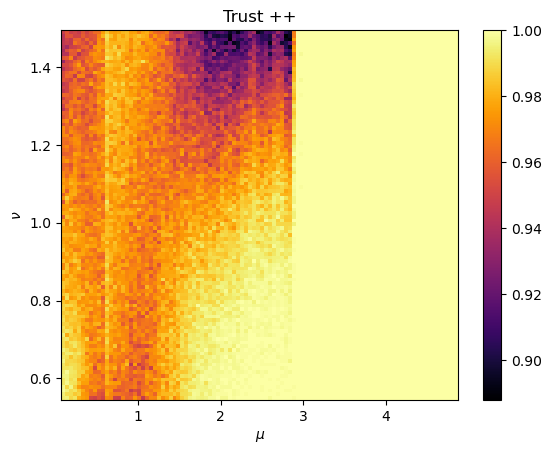

In [ ]:
z = nuisance_poisson_list[1].reshape(100, 100)


fig = plt.figure()
pc = plt.pcolormesh(mu_v, 
                    nu_v, 
                    z, 
                    vmin= np.min(nuisance_poisson_list[1]),
                    vmax=1,
                    cmap = "inferno")
fig.colorbar(pc)
plt.ylabel(r'$\nu$')
plt.xlabel(r'$\mu$')
plt.title('Trust ++')
plt.show()

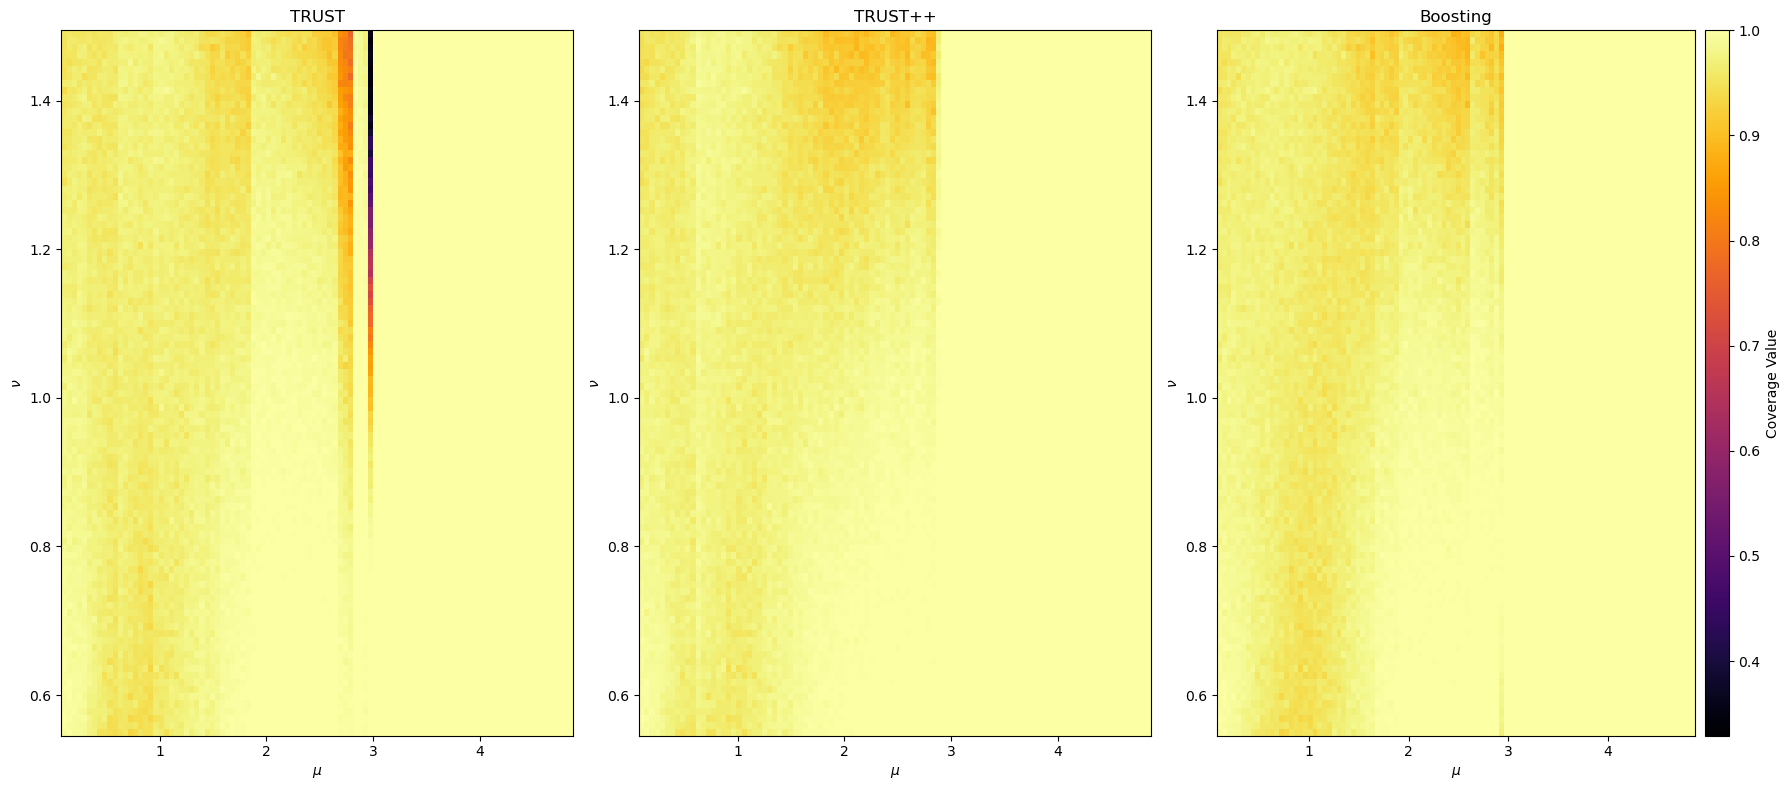

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
trust_plus_coverage = nuisance_poisson_list[1].reshape(100, 100)
trust_coverage = nuisance_poisson_list[0].reshape(100, 100)
boosting_coverage = nuisance_poisson_list[11].reshape(100, 100)
naive_coverage = nuisance_poisson_list[13].reshape(100, 100)

# Calculate global vmin and vmax
global_vmin = min(
    np.min(trust_plus_coverage), 
    np.min(trust_coverage), 
    np.min(boosting_coverage),
)
global_vmax = max(
    np.max(trust_plus_coverage), 
    np.max(trust_coverage), 
    np.max(boosting_coverage),
)

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Plot TRUST Coverage
pc1 = axes[0].pcolormesh(mu_v, nu_v, trust_coverage, 
                         vmin=global_vmin, 
                         vmax=global_vmax, 
                         cmap='inferno')
axes[0].set_ylabel(r'$\nu$')
axes[0].set_xlabel(r'$\mu$')
axes[0].set_title("TRUST")

# Plot TRUST Plus Coverage
pc2 = axes[1].pcolormesh(
    mu_v, 
    nu_v, 
    trust_plus_coverage, 
    vmin=global_vmin, 
    vmax=global_vmax, 
    cmap='inferno',
    )
axes[1].set_ylabel(r'$\nu$')
axes[1].set_xlabel(r'$\mu$')
axes[1].set_title("TRUST++")


# Plot Boosting Coverage
pc3 = axes[2].pcolormesh(mu_v, nu_v, boosting_coverage, 
                         vmin=global_vmin, 
                         vmax=global_vmax, 
                         cmap='inferno')
axes[2].set_ylabel(r'$\nu$')
axes[2].set_xlabel(r'$\mu$')
axes[2].set_title("Boosting")

# Create a colorbar axis next to the third subplot
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.1)

# Add a common colorbar
cbar = fig.colorbar(pc3, cax=cax)
cbar.set_label('Coverage Value')

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the right margin to make space for the colorbar

# Show the plot
plt.show()

Plotting heatmap for LOCART cutoffs:

Text(0.5, 1.0, 'TRUST cutoffs')

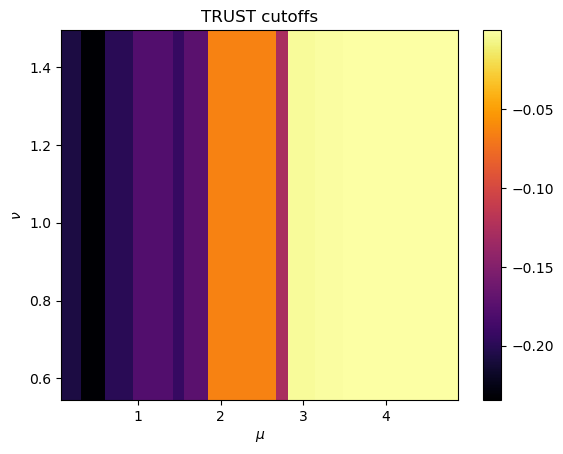

In [ ]:
z = nuisance_poisson_list[2].reshape(100, 100)
fig = plt.figure()
pc = plt.pcolormesh(mu_v, 
                    nu_v, 
                    z, 
                    vmin= np.min(nuisance_poisson_list[2]),
                    vmax=np.max(nuisance_poisson_list[2]), 
                    cmap = "inferno")
fig.colorbar(pc)
plt.ylabel(r'$\nu$')
plt.xlabel(r'$\mu$')
plt.title("TRUST cutoffs")

Real cutoffs:

Text(0.5, 1.0, 'Real cutoffs')

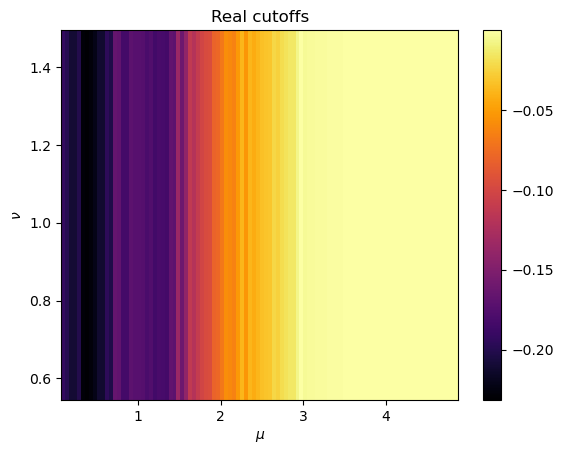

In [ ]:
z = nuisance_poisson_list[3].reshape(100, 100)
fig = plt.figure()
pc = plt.pcolormesh(mu_v, 
                    nu_v, 
                    z, 
                    vmin= np.min(nuisance_poisson_list[3]),
                    vmax=np.max(nuisance_poisson_list[3]), 
                    cmap = "inferno")
fig.colorbar(pc)
plt.ylabel(r'$\nu$')
plt.xlabel(r'$\mu$')
plt.title("Real cutoffs")

Text(0.5, 1.0, 'TRUST++ cutoffs')

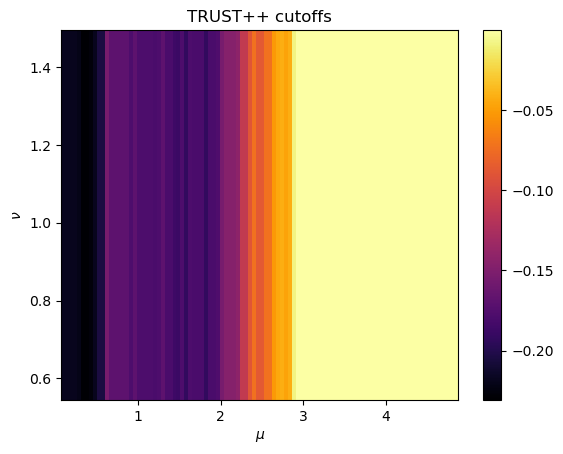

In [ ]:
z = nuisance_poisson_list[4].reshape(100, 100)
fig = plt.figure()
pc = plt.pcolormesh(mu_v, 
                    nu_v, 
                    z, 
                    vmin= np.min(nuisance_poisson_list[4]),
                    vmax=np.max(nuisance_poisson_list[4]), 
                    cmap = "inferno")
fig.colorbar(pc)
plt.ylabel(r'$\nu$')
plt.xlabel(r'$\mu$')
plt.title("TRUST++ cutoffs")

#### Plotting and evaluating difference in coverage between each method and the oracle:

Obtaining mean difference of each method coverage compared to the oracle coverage:

In [ ]:
trust_plus_coverage = nuisance_poisson_list[1]
trust_coverage = nuisance_poisson_list[0]
boosting_coverage = nuisance_poisson_list[11]
real_cutoffs = nuisance_poisson_list[3]
naive_coverage = nuisance_poisson_list[13]


diff_list = oracle_dist(
    trust_coverage,
    trust_plus_coverage,
    boosting_coverage,
    naive_coverage,
    real_cutoffs,
    valid_thetas,
    n_rep = 10,
    simulator = simulator,
    score = bff_score,
    nuisance_idx = 0,
    glm = False,
    seed = 750
)

Repeating computation: 100%|██████████| 10/10 [45:32<00:00, 273.21s/it]


Mean difference to oracle with standard error:

In [ ]:
diff_list[4]

,methods,diff,se*2
0,TRUST,0.008367,0.000023
1,TRUST++,0.006484,0.000021
2,Boosting,0.006430,0.000025
3,MC,0.150563,0.000011


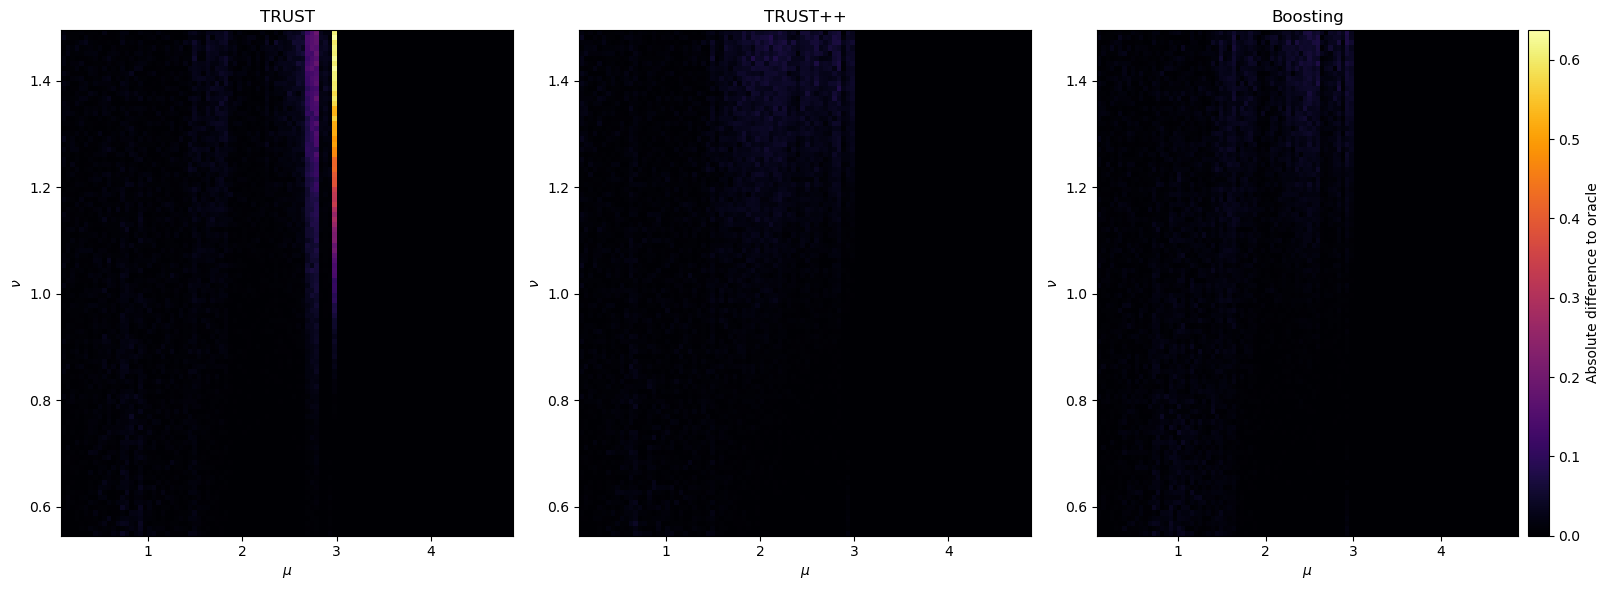

In [ ]:
trust_plus_diff = diff_list[1].reshape(100, 100)
trust_diff = diff_list[0].reshape(100, 100)
boosting_diff = diff_list[2].reshape(100, 100)

# Calculate global vmin and vmax
global_vmin = min(
    np.min(trust_plus_diff), 
    np.min(trust_diff), 
    np.min(boosting_diff),
)
global_vmax = max(
    np.max(trust_plus_diff), 
    np.max(trust_diff), 
    np.max(boosting_diff),
)

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot TRUST Coverage
pc1 = axes[0].pcolormesh(mu_v, nu_v, trust_diff, 
                         vmin=global_vmin, 
                         vmax=global_vmax, 
                         cmap='inferno')
axes[0].set_ylabel(r'$\nu$')
axes[0].set_xlabel(r'$\mu$')
axes[0].set_title("TRUST")

# Plot TRUST Plus Coverage
pc2 = axes[1].pcolormesh(
    mu_v, 
    nu_v, 
    trust_plus_diff, 
    vmin=global_vmin, 
    vmax=global_vmax, 
    cmap='inferno',
    )
axes[1].set_ylabel(r'$\nu$')
axes[1].set_xlabel(r'$\mu$')
axes[1].set_title("TRUST++")


# Plot Boosting Coverage
pc3 = axes[2].pcolormesh(mu_v, nu_v, boosting_diff, 
                         vmin=global_vmin, 
                         vmax=global_vmax, 
                         cmap='inferno')
axes[2].set_ylabel(r'$\nu$')
axes[2].set_xlabel(r'$\mu$')
axes[2].set_title("Boosting")

# Create a colorbar axis next to the third subplot
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.1)

# Add a common colorbar
cbar = fig.colorbar(pc3, cax=cax)
cbar.set_label('Absolute difference to oracle')

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the right margin to make space for the colorbar

# Show the plot
plt.show()

### GLM model with two parameters, one nuisance:

In [ ]:
# Step 1: Generate synthetic data
np.random.seed(45)
n_samples = 50
X = np.random.uniform(1, 10, (n_samples,2))
# Generate response variable with Gamma noise
y = np.random.gamma(
    shape=2, 
    scale=(1/2)*np.exp(0.5 * X[:, 0]), 
    size=n_samples)
X_new = sm.add_constant(X)

# Step 2: Fit a GLM model with Gamma distribution and log link function
glm_gamma = sm.GLM(y, X_new, family=sm.families.Gamma(link=sm.families.links.log()), )
result = glm_gamma.fit()

# Step 3: Summarize the results
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   50
Model:                            GLM   Df Residuals:                       47
Model Family:                   Gamma   Df Model:                            2
Link Function:                    log   Scale:                         0.67456
Method:                          IRLS   Log-Likelihood:                -198.00
Date:                Tue, 03 Sep 2024   Deviance:                       28.019
Time:                        19:12:22   Pearson chi2:                     31.7
No. Iterations:                    15   Pseudo R-squ. (CS):             0.8984
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2875      0.346     -0.830      0.4

/home/kuben45/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


Implementing prior for GLM, using common priors in literature:

In [52]:
# beta_0 parameters space and prior: N(0,16)
# beta_1 parameter space and prior: N(0,1)
# beta_2 parameter space and prior: N(0,1)
# using log link function
# beta_0 fixed as 1
# phi ~ exp(1)
# simulating covariate matrix first:
n = 50
rng = np.random.default_rng(45)

X_mat = rng.uniform((-1, -1), (1, 1), (n, 2))

def prior(n, rng, intercept_value = None, dim = 2):
    if intercept_value is None:
        betas = rng.normal(loc = 
                       np.repeat(0, dim + 1), 
                       scale = np.concatenate(
                           (np.array([2.0]), np.repeat(1.0, dim))
                           ),
                        size = (n, dim + 1)
                       )
    else:
        betas = rng.normal(loc = 0,
                           scale = 1,
                           size = (n, dim))
        betas = np.column_stack((np.repeat(intercept_value, n),
                                 betas))
    # truncating exponential values at 2.25
    phi = rng.standard_exponential(n)
    phi[np.where(phi > 1.75)] = 1.75
    return betas, phi

Declaring glm model and using it to simulate data:

In [53]:
# defining GLM_stats
glm_class = GLM_stat(
    prior_func=prior,
    X_mat = X_mat,
    rng = rng,
    dist = "gamma",
    link_func = "log",
)

glm_class

Fitting all methods in the glm problem:

In [54]:
print("Sampling from the parameter prior and simulating sample:")
B = 10000
# using GLM class
thetas_sim, model_lambdas = glm_class.LR_sample(
    B = B, 
    idx_1 = np.array([1]), 
    fit_intercept = True,
    )

if thetas_sim.ndim == 1:
    model_thetas = thetas_sim.reshape(-1, 1)
else:
    model_thetas = thetas_sim

print("Fitting our methods: ")
print("Fitting TRUST ")
trust_object = LocartSplit(
        LambdaScore, None, alpha=0.05, is_fitted=True, split_calib=False
    )
trust_quantiles = trust_object.calib(
    thetas_sim, model_lambdas, min_samples_leaf=300
)

# loforest quantiles
print("Fitting TRUST++")
trust_plus_object = ConformalLoforest(
    LambdaScore, None, alpha=0.05, is_fitted=True, split_calib=False
)
trust_plus_object.calibrate(
    thetas_sim,
    model_lambdas,
    min_samples_leaf=300,
    n_estimators=200,
    K=100,
)

# training boosting
boosting_object =  HistGradientBoostingRegressor(
        loss="quantile",
        max_iter=100,
        max_depth=3,
        quantile= 0.95,
        random_state=105,
        n_iter_no_change=15,
        early_stopping=True,
    )
boosting_object.fit(thetas_sim, model_lambdas)

Sampling from the parameter prior and simulating sample:


/home/kuben45/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


Fitting our methods: 
Fitting TRUST 
Fitting TRUST++


HistGradientBoostingRegressor(early_stopping=True, loss='quantile', max_depth=3,
                              n_iter_no_change=15, quantile=0.95,
                              random_state=105)

Computing all nuisance cutoffs for a random grid

In [55]:
valid_rng = np.random.default_rng(67)
# fixing only beta_1 values
beta_nuis_space = np.linspace(-2, 2, 15)

beta_space, phi_space = prior(n = 50, rng = valid_rng)
# joining parameters together
valid_thetas = np.concatenate(
    (beta_space, phi_space.reshape(-1, 1)), axis=1)

valid_thetas_del = np.delete(valid_thetas, 1, axis = 1)

# obtaining combination
valid_tile = np.tile(valid_thetas_del, (15,1))
beta_1_tile = np.tile(beta_nuis_space, 50)
# beta_space = np.linspace(-1.9, 1.9, 20)
# beta_0_space = np.linspace(-3, 3, 20)
# phi_space = np.linspace(0.1, 3, 20)

# returning all combinations for fitting nuissance cutoffs
# valid_thetas = np.c_[list(itertools.product(
#  beta_0_space, beta_space, beta_space, phi_space))]
valid_thetas = np.insert(valid_tile, 1, beta_1_tile, axis = 1)

In [58]:
# nuisance grid for boosting
beta_b_nuis_space = np.linspace(-1.9, 1.9, 26)
beta_0_nuis_space = np.linspace(-3, 3, 26)
phi_nuis_space = np.linspace(0.05,1.745, 26)

nuisance_grid_boosting = np.c_[list(itertools.product(
    beta_0_nuis_space, beta_b_nuis_space, phi_nuis_space))]

# obtaining cutoffs for each mu
cutoff_mu_TRUST = TRUST_nuisance_cutoffs(
    trust_object, 
    nuissance_idx = np.array([0,2,3]), 
    par_values = beta_nuis_space.reshape(-1, 1), 
    trust_quantiles = trust_quantiles, 
    )

cutoff_mu_TRUST_plus = TRUST_plus_nuisance_cutoff(
    trust_plus_object,
    nuissance_idx = np.array([0,2,3]),
    par_values = beta_nuis_space.reshape(-1, 1),
    K = 100,
    strategy = "horizontal_cutoffs",
    total_h_cutoffs = 50,
)

cutoff_mu_boosting = boosting_nuisance_cutoff(
    boosting_object, 
    nuisance_grid = nuisance_grid_boosting, 
    nuissance_idx= np.array([0,2,3]),
    par_values = beta_nuis_space.reshape(-1, 1),
    )

Total number of combinations: 18432


Computing nuisance cutoffs for each parameter value: 100%|██████████| 15/15 [09:29<00:00, 37.93s/it]
Computing nuisance cutoffs for each parameter value in boosting: 100%|██████████| 15/15 [00:00<00:00, 135.96it/s]


In [59]:
pars = valid_thetas[6, :]
beta_test = pars[0:3]
phi_test = pars[3]

In [60]:
nuisance_glm_list = coverage_nuisance_glm(
    cutoff_mu_TRUST, 
    cutoff_mu_TRUST_plus,
    cutoff_mu_boosting, 
    valid_thetas, 
    par_space = beta_nuis_space,
    par_idx = np.array([1]),
    glm_class = glm_class,
    n_lambda = 75,
    )

Assessing :   0%|          | 0/750 [00:00<?, ?it/s]/home/kuben45/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
Computing real cutoffs: 100%|██████████| 750/750 [00:00<00:00, 4490.40it/s]


[  0  15  30  45  60  75  90 105 120 135 150 165 180 195 210 225 240 255
 270 285 300 315 330 345 360 375 390 405 420 435 450 465 480 495 510 525
 540 555 570 585 600 615 630 645 660 675 690 705 720 735]
[  1  16  31  46  61  76  91 106 121 136 151 166 181 196 211 226 241 256
 271 286 301 316 331 346 361 376 391 406 421 436 451 466 481 496 511 526
 541 556 571 586 601 616 631 646 661 676 691 706 721 736]
[  2  17  32  47  62  77  92 107 122 137 152 167 182 197 212 227 242 257
 272 287 302 317 332 347 362 377 392 407 422 437 452 467 482 497 512 527
 542 557 572 587 602 617 632 647 662 677 692 707 722 737]
[  3  18  33  48  63  78  93 108 123 138 153 168 183 198 213 228 243 258
 273 288 303 318 333 348 363 378 393 408 423 438 453 468 483 498 513 528
 543 558 573 588 603 618 633 648 663 678 693 708 723 738]
[  4  19  34  49  64  79  94 109 124 139 154 169 184 199 214 229 244 259
 274 289 304 319 334 349 364 379 394 409 424 439 454 469 484 499 514 529
 544 559 574 589 604 619 634 649 664 6

Computing cutoffs only for mu:   0%|          | 0/15 [00:00<?, ?it/s]


In [61]:
nuisance_glm_list[0]

array([0.94666667, 0.96      , 1.        , 0.97333333, 0.96      ,
       0.94666667, 0.93333333, 0.89333333, 0.97333333, 0.97333333,
       0.94666667, 0.96      , 0.96      , 0.97333333, 0.94666667,
       0.97333333, 0.97333333, 0.93333333, 0.98666667, 0.96      ,
       0.93333333, 0.90666667, 0.92      , 0.94666667, 0.94666667,
       0.97333333, 0.90666667, 0.96      , 0.94666667, 0.98666667,
       0.94666667, 0.90666667, 0.90666667, 0.92      , 0.94666667,
       0.98666667, 0.96      , 0.97333333, 0.96      , 0.93333333,
       0.96      , 0.88      , 0.94666667, 0.93333333, 0.96      ,
       0.96      , 0.93333333, 0.97333333, 0.94666667, 0.90666667,
       0.94666667, 0.96      , 0.92      , 0.96      , 0.97333333,
       0.93333333, 0.90666667, 0.96      , 0.97333333, 0.89333333,
       0.93333333, 0.97333333, 0.92      , 1.        , 0.93333333,
       0.98666667, 0.98666667, 0.97333333, 0.96      , 0.94666667,
       0.96      , 0.92      , 0.86666667, 0.94666667, 0.94666

In [62]:
nuisance_glm_list[1]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97333333, 1.        , 1.        , 1.        ,
       0.98666667, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.98666667, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.98666667, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.98666667, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.98666667, 1.        , 1.     

In [63]:
nuisance_glm_list[9]

array([0.96      , 0.98666667, 1.        , 0.98666667, 0.97333333,
       0.96      , 0.93333333, 0.90666667, 1.        , 0.98666667,
       0.96      , 0.97333333, 0.97333333, 1.        , 0.97333333,
       0.98666667, 0.98666667, 0.96      , 1.        , 0.97333333,
       0.97333333, 0.93333333, 0.93333333, 0.94666667, 0.96      ,
       0.98666667, 0.94666667, 0.96      , 0.96      , 0.98666667,
       1.        , 0.94666667, 0.92      , 0.94666667, 0.97333333,
       1.        , 0.98666667, 0.97333333, 0.97333333, 0.94666667,
       0.97333333, 0.93333333, 0.97333333, 0.94666667, 0.97333333,
       0.96      , 0.94666667, 0.98666667, 0.98666667, 0.98666667,
       0.96      , 0.97333333, 0.96      , 0.96      , 0.97333333,
       0.94666667, 0.94666667, 0.98666667, 0.98666667, 0.96      ,
       0.97333333, 1.        , 0.96      , 1.        , 0.96      ,
       0.98666667, 1.        , 0.97333333, 0.97333333, 0.98666667,
       0.96      , 0.98666667, 0.90666667, 0.98666667, 0.96   

In [64]:
trust_plus_coverage = nuisance_glm_list[1]
trust_coverage = nuisance_glm_list[0]
real_cutoffs = nuisance_glm_list[3]
boosting_coverage = nuisance_glm_list[9]
asymp_coverage = nuisance_glm_list[11]

diff_list = oracle_dist_glm(
    trust_coverage,
    trust_plus_coverage,
    boosting_coverage,
    asymp_coverage,
    real_cutoffs,
    valid_thetas,
    glm_class = glm_class,
    n_rep = 5,
    par_idx = np.array([1]),
    n_lambda = 100,
)

Repeating computation: 100%|██████████| 5/5 [2:18:22<00:00, 1660.53s/it]  


In [66]:
diff_list[3]

,methods,diff,se*2
0,TRUST,0.035382,0.000473
1,TRUST++,0.016276,0.000349
2,Boosting,0.021828,0.000313
3,Asymptotic,0.049894,0.000542
